# Station-Shares

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
import seaborn as sns

Daten einlesen & vorbereiten:

In [2]:
df = pd.read_csv('../daten/Emmental.csv', sep=';')

In [3]:
# Datetime-Spalten erstellen
df = df[['status', 'timestamps.effective_pickup', 'timestamps.effective_dropoff', 'pickup.station_chosen_confirmation_addr', 'dropoff.station_chosen_confirmation_addr']]
df['timestamps.effective_pickup'] = pd.to_datetime(df['timestamps.effective_pickup'])
df['timestamps.effective_dropoff'] = pd.to_datetime(df['timestamps.effective_dropoff'])

In [4]:
# Nur Fahrten übernehmen, die tatsächlich stattgefunden haben
df = df[df['timestamps.effective_dropoff'].notna() & df['timestamps.effective_pickup'].notna()]
df = df[df['status'] == 'FINISHED']
len(df)

14855

In [5]:
# Nur relevante Spalten übernehmen
df = df[['timestamps.effective_pickup', 'pickup.station_chosen_confirmation_addr', 'status']]

In [6]:
df

,timestamps.effective_pickup,pickup.station_chosen_confirmation_addr,status
9,2020-08-22 11:37:59,Rüegsauschachen - Gerbestrasse 3_inaktiv_2021-...,FINISHED
10,2020-08-22 11:42:47,Rüegsauschachen - Gerbestrasse 3_inaktiv_2021-...,FINISHED
12,2020-08-22 11:49:20,Rüegsau - Mühlegasse 5_alt_2021-01-31,FINISHED
15,2020-08-23 16:58:03,Hasle-Rüegsau - Bahnhof (BLS),FINISHED
16,2020-08-23 17:11:56,Affoltern i.E. - Emmentaler Schaukäserei,FINISHED
...,...,...,...
29355,2023-01-10 19:01:00,Burgdorf - Bahnhof (BLS),FINISHED
29356,2023-01-10 19:57:47,Hasle b.B. - Gewerbepark Dicki,FINISHED
29358,2023-01-10 20:24:38,Hasle-Rüegsau - Bahnhof (BLS),FINISHED
29360,2023-01-10 21:55:33,Rüegsauschachen - Schulhaus,FINISHED


Hilfs-DF's erstellen: 

In [8]:
# Alle verfügbaren Stationen
all_stations = df['pickup.station_chosen_confirmation_addr'].unique()

In [9]:
# Alle Stationen bekommen einen Eintrag für jede Stunde
empty_stations = pd.DataFrame(list(product(range(24), all_stations)), columns=['Stunde', 'Station'])

Share Anteil pro Station & Stunde (jeder Tag separat) berechnen:

In [10]:
# Neues DF mit Counts pro Stunde & Station erstellen
daily = df[['timestamps.effective_pickup', 'status', 'pickup.station_chosen_confirmation_addr']]
daily = daily.groupby([pd.Grouper(key='timestamps.effective_pickup', freq='D'), pd.Grouper(key='timestamps.effective_pickup', freq='H'), 'pickup.station_chosen_confirmation_addr']).count()
daily.index.names = ['days', 'days_hours', 'station']
daily = pd.DataFrame({'Datum': daily.index.get_level_values('days_hours'), 'Station': daily.index.get_level_values('station'), 'cnt': daily.reset_index()['status']})

In [11]:
# Für jede Station & Stunde einen Wert einfügen (falls nicht vorhanden --> 0-Werte ergänzen)
date_range = pd.DataFrame(pd.date_range(start=daily.Datum.dt.date.min(), end=daily.Datum.dt.date.max(), freq='H'), columns=['Datum'])
daily_new = daily.drop(daily.index)

for name in daily.Station.unique():
    station_df = daily[daily.Station == name]
    station_df_full = pd.merge(date_range, station_df, on=['Datum'], how='left')
    station_df_full['cnt'] = station_df_full['cnt'].fillna(0)
    station_df_full['Station'] = station_df.iloc[0].Station
    daily_new = pd.concat([daily_new, station_df_full])

In [12]:
# Nach Datetime sortieren
daily_new = daily_new.sort_values('Datum')
daily = daily_new

In [14]:
# Prozentwerte (Share-Anteile) berechnen
hour_groups = daily.groupby('Datum')
percentages = []
for hour, hour_df in hour_groups:
    total_cnt = hour_df['cnt'].sum()
    hour_df['percentage'] = hour_df['cnt'] / total_cnt
    [percentages.append(x) for x in hour_df['percentage']]
daily['share'] = percentages
daily.share = daily.share.fillna(0)
    

In [17]:
daily

,Datum,Station,cnt,share
0,2020-08-22,Rüegsau - Mühlegasse 5_alt_2021-01-31,0.0,0.0
0,2020-08-22,Schafhausen i.E. - Bahnhof (BLS),0.0,0.0
0,2020-08-22,Lützelflüh - Waldhaus / DAHLIENSCHAU,0.0,0.0
0,2020-08-22,Lützelflüh - Emmestrasse 1,0.0,0.0
0,2020-08-22,Lützelflüh - Restaurant Thalsäge_alt_2022-07-01,0.0,0.0
...,...,...,...,...
20904,2023-01-10,Rüegsauschachen - Otzenberg,0.0,0.0
20904,2023-01-10,Heimiswil - Busswil Ost,0.0,0.0
20904,2023-01-10,Goldbach - Emmentalstrasse 36_inaktiv_2021-09-01,0.0,0.0
20904,2023-01-10,Affoltern i.E. - Nothalden 1,0.0,0.0


Stations-Mapping auf Zahlen (Stations-Nr.):

In [18]:
daily['station_nr'] = [np.where(all_stations == x)[0][0] for x in daily['Station']]

In [19]:
print(len(daily['station_nr'].unique()))
print(len(daily['Station'].unique()))

208
208


<AxesSubplot:>

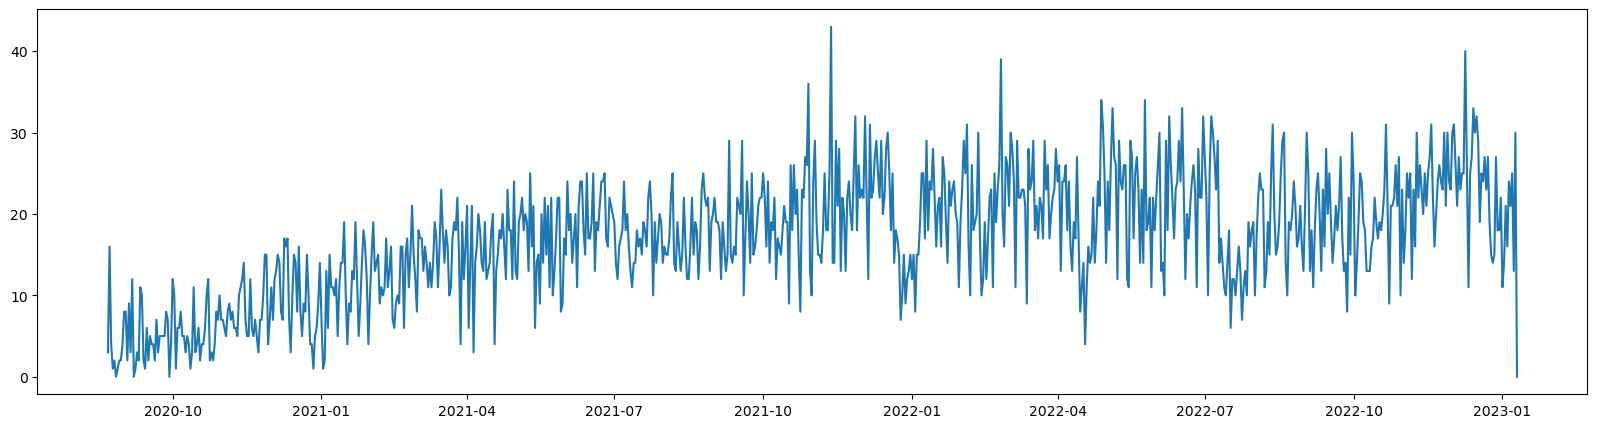

In [111]:
daily.groupby(daily.index.date).cnt.sum().plot(figsize=(20,5))

Neue Spalten für einzelne Teile von Datetime hinzufügen:

In [20]:
daily['date_unix'] = daily['Datum'].apply(lambda x: x.timestamp())
daily['year'] = daily['Datum'].dt.year
daily['month'] = daily['Datum'].dt.month
daily['weekday'] = daily['Datum'].dt.weekday
daily['hour'] = daily['Datum'].dt.hour

In [21]:
# Datetime als Index-Spalte definieren
daily = daily.set_index('Datum')
daily = daily.sort_index()

In [24]:
daily

,Station,cnt,share,station_nr,date_unix,year,month,weekday,hour
Datum,,,,,,,,,
2020-08-22,Rüegsau - Mühlegasse 5_alt_2021-01-31,0.0,0.0,1,1.598054e+09,2020,8,5,0
2020-08-22,Schafhausen i.E. - Bahnhof (BLS),0.0,0.0,23,1.598054e+09,2020,8,5,0
2020-08-22,Lützelflüh - Waldhaus / DAHLIENSCHAU,0.0,0.0,199,1.598054e+09,2020,8,5,0
2020-08-22,Lützelflüh - Emmestrasse 1,0.0,0.0,206,1.598054e+09,2020,8,5,0
2020-08-22,Lützelflüh - Restaurant Thalsäge_alt_2022-07-01,0.0,0.0,170,1.598054e+09,2020,8,5,0
...,...,...,...,...,...,...,...,...,...
2023-01-10,Rüegsauschachen - Otzenberg,0.0,0.0,133,1.673309e+09,2023,1,1,0
2023-01-10,Heimiswil - Busswil Ost,0.0,0.0,132,1.673309e+09,2023,1,1,0
2023-01-10,Goldbach - Emmentalstrasse 36_inaktiv_2021-09-01,0.0,0.0,131,1.673309e+09,2023,1,1,0


Aufteilung Trainings-, Validierungs- & Testdaten:

In [25]:
%load_ext autoreload
%autoreload 2
import rt_processing

In [26]:
m01_train, m01_val, m01_test = rt_processing.train_val_test_auswahl(daily, '2020-08-22', '2021-12-31', 0)
m02_train, m02_val, m02_test = rt_processing.train_val_test_auswahl(daily, '2020-08-22', '2022-01-31', 0)
m03_train, m03_val, m03_test = rt_processing.train_val_test_auswahl(daily, '2020-08-22', '2022-02-28', 0)
m04_train, m04_val, m04_test = rt_processing.train_val_test_auswahl(daily, '2020-08-22', '2022-03-31', 0)
m05_train, m05_val, m05_test = rt_processing.train_val_test_auswahl(daily, '2020-08-22', '2022-04-30', 0)
m06_train, m06_val, m06_test = rt_processing.train_val_test_auswahl(daily, '2020-08-22', '2022-05-31', 0)
m07_train, m07_val, m07_test = rt_processing.train_val_test_auswahl(daily, '2020-08-22', '2022-06-30', 0)
m08_train, m08_val, m08_test = rt_processing.train_val_test_auswahl(daily, '2020-08-22', '2022-07-31', 0)
m09_train, m09_val, m09_test = rt_processing.train_val_test_auswahl(daily, '2020-08-22', '2022-08-31', 0)
m10_train, m10_val, m10_test = rt_processing.train_val_test_auswahl(daily, '2020-08-22', '2022-09-30', 0)
m11_train, m11_val, m11_test = rt_processing.train_val_test_auswahl(daily, '2020-08-22', '2022-10-31', 0)

start_date_val:  2022-01-01 00:00:00 ⎮ end_date_val:  2022-01-31 00:00:00
start_date_test: 2022-02-01 00:00:00 ⎮ end_date_test: 2022-02-28 00:00:00 

start_date_val:  2022-02-01 00:00:00 ⎮ end_date_val:  2022-02-28 00:00:00
start_date_test: 2022-03-01 00:00:00 ⎮ end_date_test: 2022-03-31 00:00:00 

start_date_val:  2022-03-01 00:00:00 ⎮ end_date_val:  2022-03-31 00:00:00
start_date_test: 2022-04-01 00:00:00 ⎮ end_date_test: 2022-04-30 00:00:00 

start_date_val:  2022-04-01 00:00:00 ⎮ end_date_val:  2022-04-30 00:00:00
start_date_test: 2022-05-01 00:00:00 ⎮ end_date_test: 2022-05-31 00:00:00 

start_date_val:  2022-05-01 00:00:00 ⎮ end_date_val:  2022-05-31 00:00:00
start_date_test: 2022-06-01 00:00:00 ⎮ end_date_test: 2022-06-30 00:00:00 

start_date_val:  2022-06-01 00:00:00 ⎮ end_date_val:  2022-06-30 00:00:00
start_date_test: 2022-07-01 00:00:00 ⎮ end_date_test: 2022-07-31 00:00:00 

start_date_val:  2022-07-01 00:00:00 ⎮ end_date_val:  2022-07-31 00:00:00
start_date_test: 2022-08-0

In [30]:
# Erstellung der DataFrames, in welchen die Modell-Bezeichnung und die vier aufgeführten Qualitätsdaten abgespeichert werden:
qual_train = pd.DataFrame(columns=['Model', 'Dataset', 'R2', 'RMSE', 'MAE', 'MAPE'])
qual_val = pd.DataFrame(columns=['Model', 'Dataset', 'R2', 'RMSE', 'MAE', 'MAPE'])
qual_test = pd.DataFrame(columns=['Model', 'Dataset', 'R2', 'RMSE', 'MAE', 'MAPE'])

Baseline:

In [31]:
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_baseline_performance(m01_train, m01_val, m01_test)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_baseline_performance(m02_train, m02_val, m02_test)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_baseline_performance(m03_train, m03_val, m03_test)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_baseline_performance(m04_train, m04_val, m04_test)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_baseline_performance(m05_train, m05_val, m05_test)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_baseline_performance(m06_train, m06_val, m06_test)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_baseline_performance(m07_train, m07_val, m07_test)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_baseline_performance(m08_train, m08_val, m08_test)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_baseline_performance(m09_train, m09_val, m09_test)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_baseline_performance(m10_train, m10_val, m10_test)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_baseline_performance(m11_train, m11_val, m11_test)

/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bac


 Baseline_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.0 
 RMSE:  0.03996890713396816 
 MAE:  0.0038382880581405796 
 MAPE:  inf
Qualität auf Validierungsdaten: 
 R-squared:  0.0 
 RMSE:  0.04424743100549102 
 MAE:  0.004903264636425186 
 MAPE:  inf

 Baseline_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.0 
 RMSE:  0.04023857265183997 
 MAE:  0.003901161530777184 
 MAPE:  inf
Qualität auf Validierungsdaten: 
 R-squared:  0.0 
 RMSE:  0.04293179281354988 
 MAE:  0.004826356357796764 
 MAPE:  inf


/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bac


 Baseline_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.0 
 RMSE:  0.04038189234305727 
 MAE:  0.003947464353263779 
 MAPE:  inf
Qualität auf Validierungsdaten: 
 R-squared:  0.0 
 RMSE:  0.04591172651511217 
 MAE:  0.005326304758735458 
 MAPE:  inf

 Baseline_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.0 
 RMSE:  0.040679985749831296 
 MAE:  0.004019260848119417 
 MAPE:  inf
Qualität auf Validierungsdaten: 
 R-squared:  0.0 
 RMSE:  0.04303331859598315 
 MAE:  0.00466041035774999 
 MAPE:  inf


/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bac


 Baseline_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.0 
 RMSE:  0.04080704156980824 
 MAE:  0.0040529653487650944 
 MAPE:  inf
Qualität auf Validierungsdaten: 
 R-squared:  0.0 
 RMSE:  0.044636368615562014 
 MAE:  0.005061127984269063 
 MAPE:  inf


/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100



 Baseline_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.0 
 RMSE:  0.04100733652326423 
 MAE:  0.004103068350076125 
 MAPE:  inf
Qualität auf Validierungsdaten: 
 R-squared:  0.0 
 RMSE:  0.04374510911985545 
 MAE:  0.004960588672526121 
 MAPE:  inf


/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100



 Baseline_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.0 
 RMSE:  0.04113911612563287 
 MAE:  0.004141745650234169 
 MAPE:  inf
Qualität auf Validierungsdaten: 
 R-squared:  0.0 
 RMSE:  0.042172742636119594 
 MAE:  0.004334171716012528 
 MAPE:  inf


/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100



 Baseline_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.0 
 RMSE:  0.0411878611789954 
 MAE:  0.004152188375269914 
 MAPE:  inf
Qualität auf Validierungsdaten: 
 R-squared:  0.0 
 RMSE:  0.04430542583514497 
 MAE:  0.004942963172660588 
 MAPE:  inf


/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100



 Baseline_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.0 
 RMSE:  0.04131960813031818 
 MAE:  0.004184910516240093 
 MAPE:  inf
Qualität auf Validierungsdaten: 
 R-squared:  0.0 
 RMSE:  0.0451272328669508 
 MAE:  0.005003440335921825 
 MAPE:  inf


/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100



 Baseline_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.0 
 RMSE:  0.04147394203670169 
 MAE:  0.004215821378638997 
 MAPE:  inf
Qualität auf Validierungsdaten: 
 R-squared:  0.0 
 RMSE:  0.046323060816337455 
 MAE:  0.005182346898822464 
 MAPE:  inf

 Baseline_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.0 
 RMSE:  0.04167618316819451 
 MAE:  0.004255059502428412 
 MAPE:  inf
Qualität auf Validierungsdaten: 
 R-squared:  0.0 
 RMSE:  0.04646949269883598 
 MAE:  0.00564549980627081 
 MAPE:  inf


/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100


Regression Tree:

None :


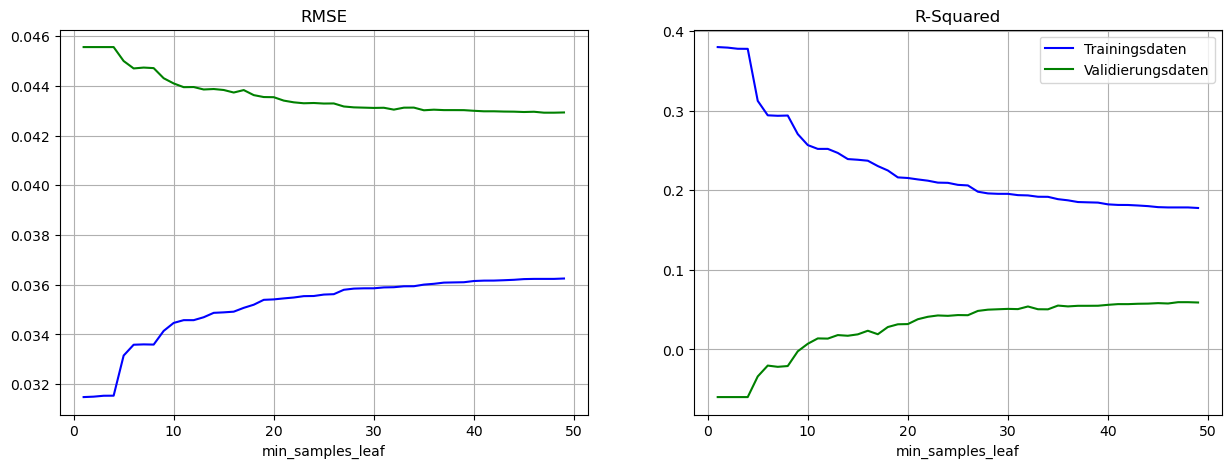

None :


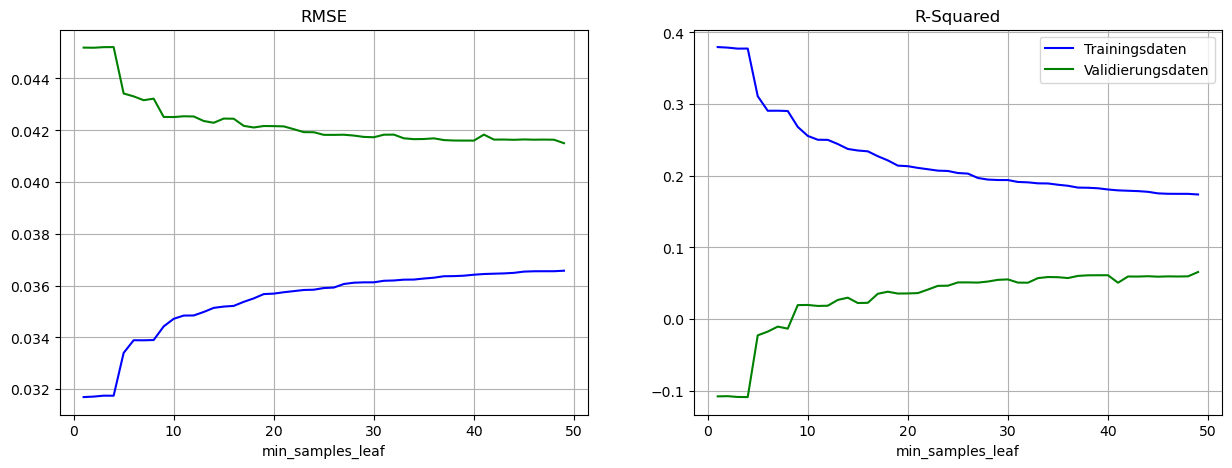

None :


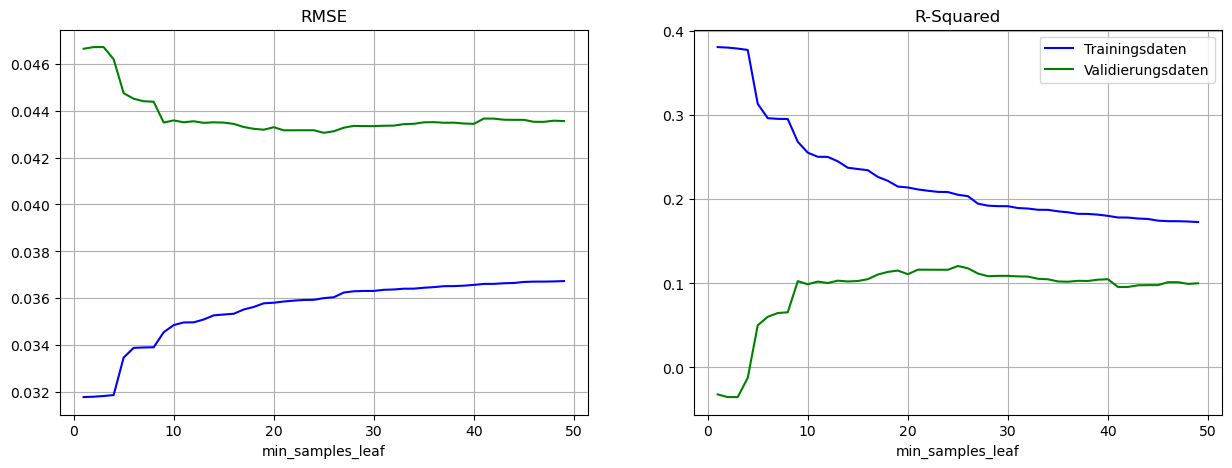

None :


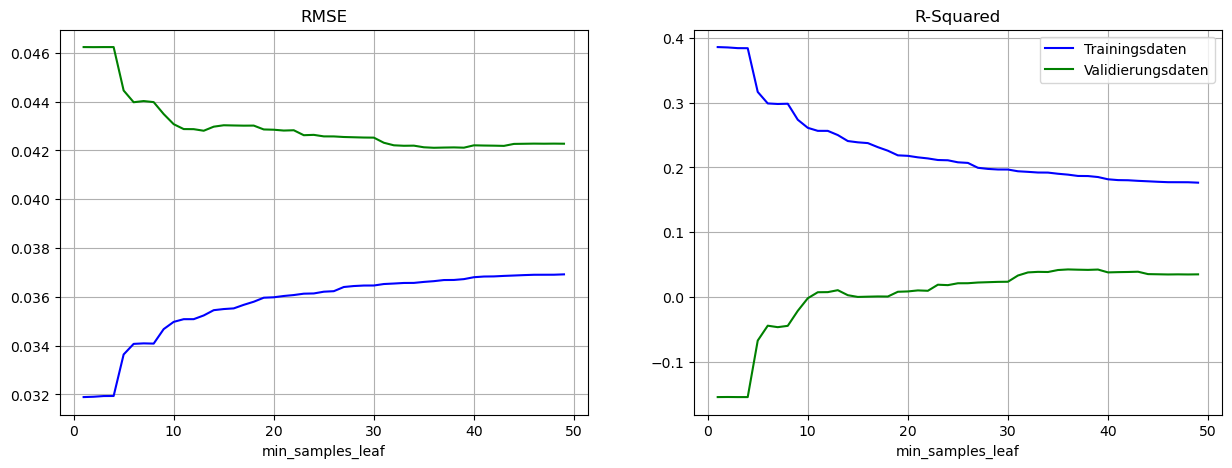

None :


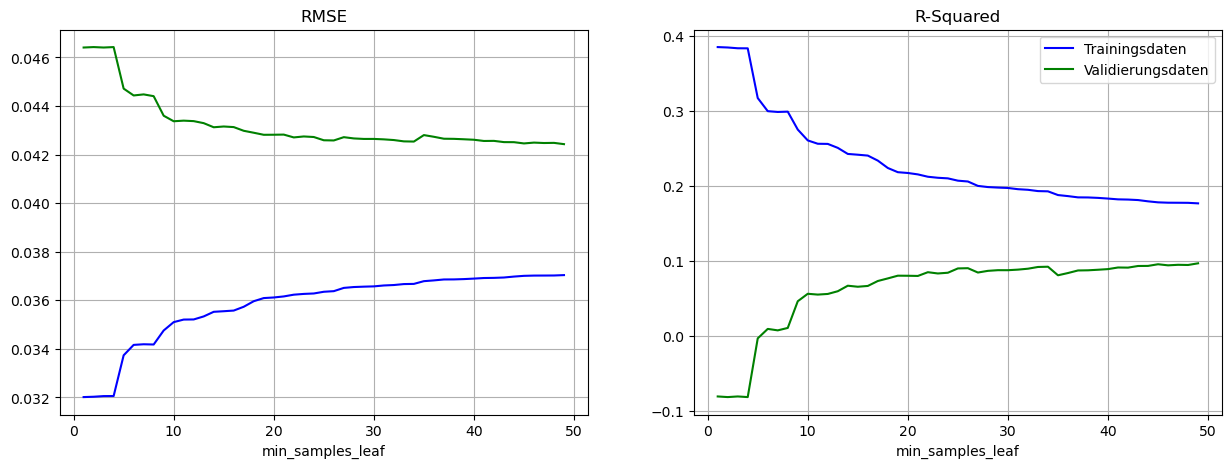

None :


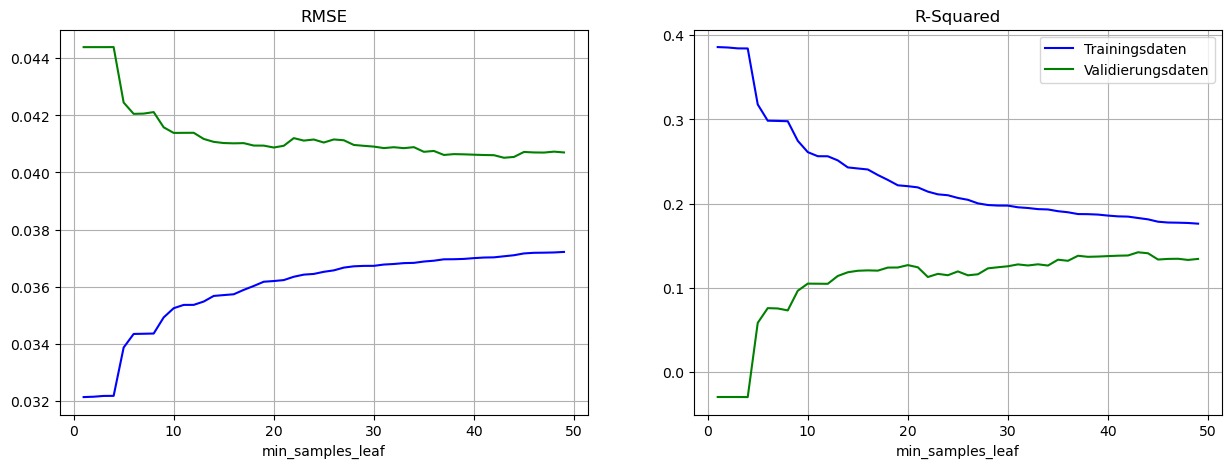

None :


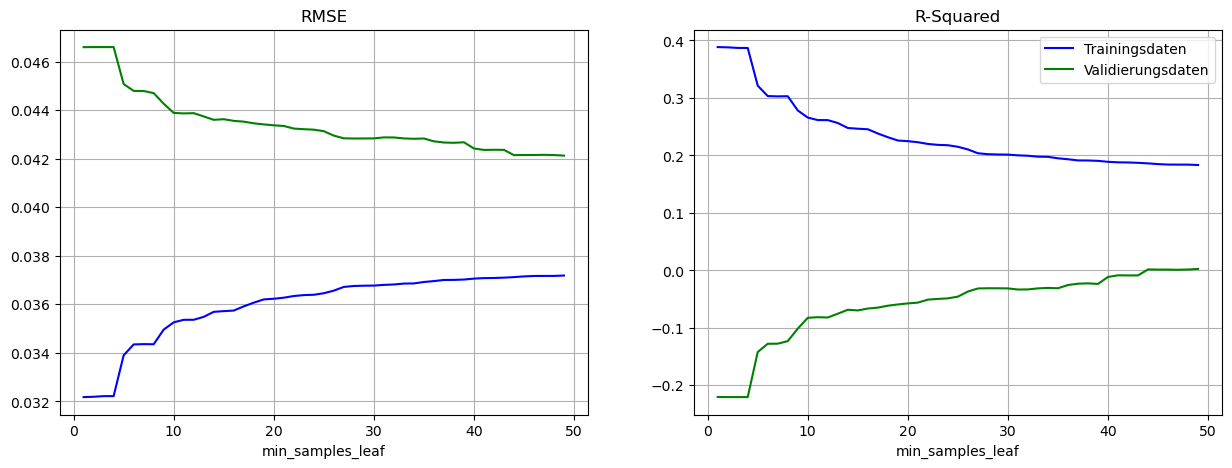

None :


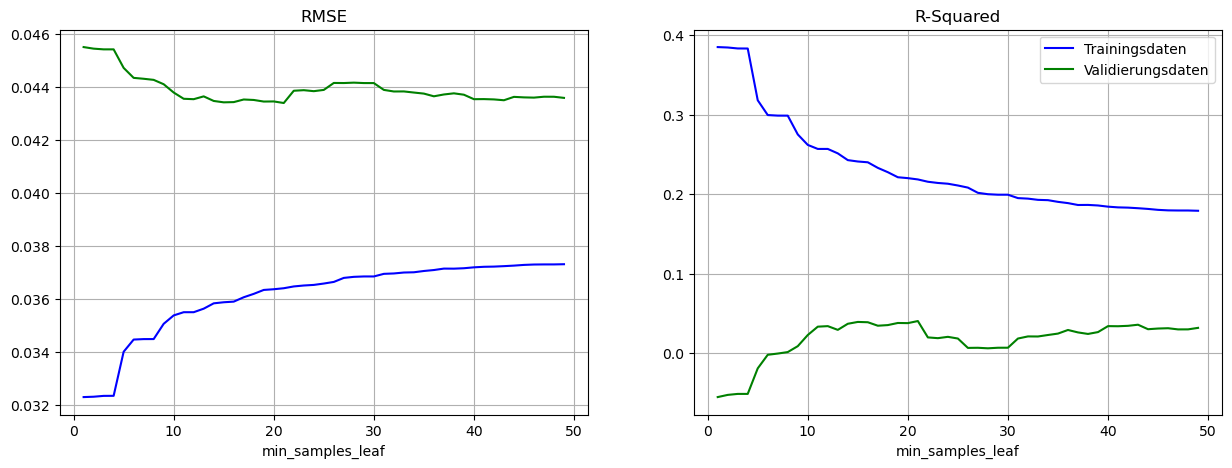

None :


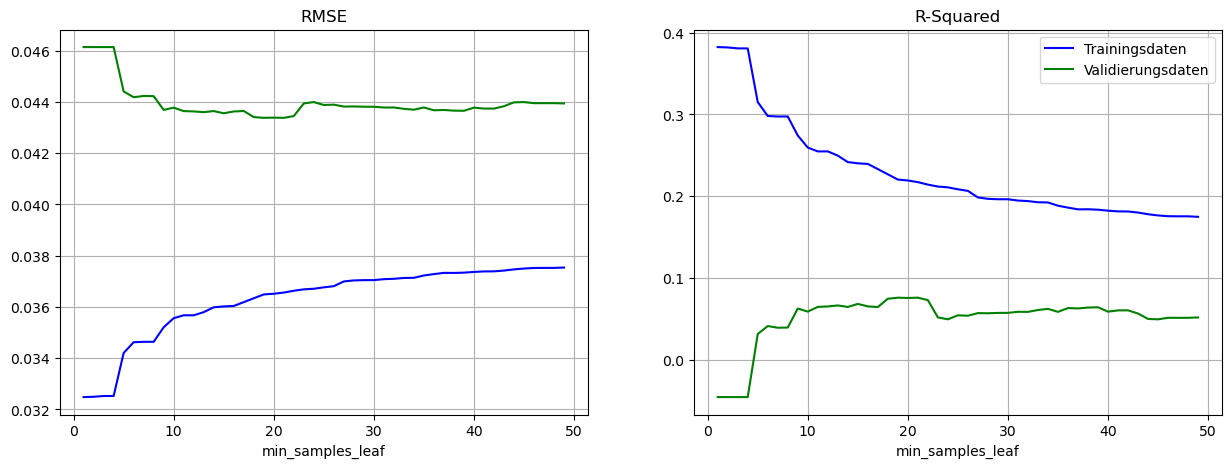

None :


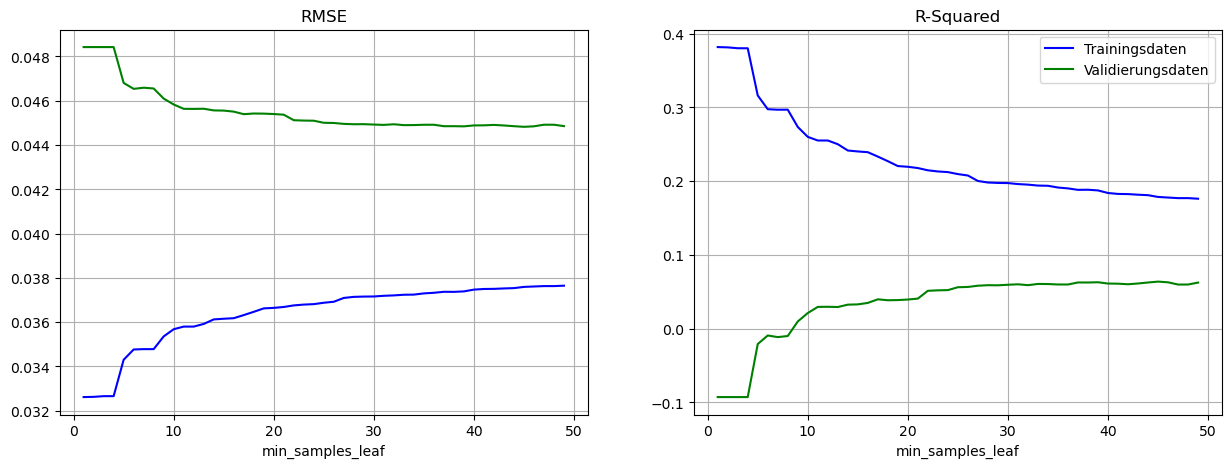

None :


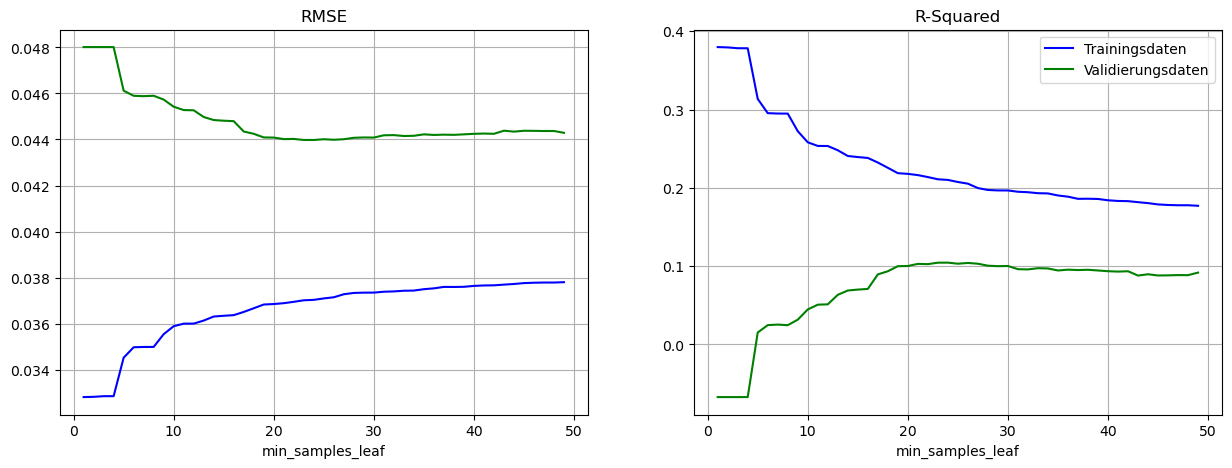

In [28]:
# Qualitätswerte für jedes Datenset mit min_samples_leaf=1-50 darstellen
rt_processing.get_rt_cv(m01_train, m01_val)
rt_processing.get_rt_cv(m02_train, m02_val)
rt_processing.get_rt_cv(m03_train, m03_val)
rt_processing.get_rt_cv(m04_train, m04_val)
rt_processing.get_rt_cv(m05_train, m05_val)
rt_processing.get_rt_cv(m06_train, m06_val)
rt_processing.get_rt_cv(m07_train, m07_val)
rt_processing.get_rt_cv(m08_train, m08_val)
rt_processing.get_rt_cv(m09_train, m09_val)
rt_processing.get_rt_cv(m10_train, m10_val)
rt_processing.get_rt_cv(m11_train, m11_val)

In [32]:
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_rt_performance(m01_train, m01_val, m01_test, 45)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_rt_performance(m02_train, m02_val, m02_test, 45)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_rt_performance(m03_train, m03_val, m03_test, 25)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_rt_performance(m04_train, m04_val, m04_test, 35)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_rt_performance(m05_train, m05_val, m05_test, 45)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_rt_performance(m06_train, m06_val, m06_test, 43)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_rt_performance(m07_train, m07_val, m07_test, 45)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_rt_performance(m08_train, m08_val, m08_test, 15)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_rt_performance(m09_train, m09_val, m09_test, 21)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_rt_performance(m10_train, m10_val, m10_test, 45)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_rt_performance(m11_train, m11_val, m11_test, 25)

/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bach


 RT_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.17863391617936386 
 RMSE:  0.03622352050993244 
 MAE:  0.0031054668842851064 
 MAPE:  nan
Qualität auf Validierungsdaten: 
 R-squared:  0.05788898393426145 
 RMSE:  0.042947619992352325 
 MAE:  0.0037806116399360956 
 MAPE:  nan


/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bach


 RT_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.17534806694313865 
 RMSE:  0.03654078791449563 
 MAE:  0.0031706588424373415 
 MAPE:  nan
Qualität auf Validierungsdaten: 
 R-squared:  0.05920424546065206 
 RMSE:  0.041641532035077554 
 MAE:  0.004416490300472134 
 MAPE:  nan


/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bach


 RT_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.20529965145588158 
 RMSE:  0.03599882854233105 
 MAE:  0.003085042609045736 
 MAPE:  nan
Qualität auf Validierungsdaten: 
 R-squared:  0.12047130743485102 
 RMSE:  0.04305748219723657 
 MAE:  0.0044407446807172785 
 MAPE:  nan


/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bach


 RT_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.190120732819411 
 RMSE:  0.036609258512402765 
 MAE:  0.0031968310217636185 
 MAPE:  nan
Qualität auf Validierungsdaten: 
 R-squared:  0.04137095206036723 
 RMSE:  0.04213375165827854 
 MAE:  0.004385204805421535 
 MAPE:  nan


/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bach


 RT_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.17778194732251906 
 RMSE:  0.03700229100977676 
 MAE:  0.0032763349590785467 
 MAPE:  nan
Qualität auf Validierungsdaten: 
 R-squared:  0.09542427296451861 
 RMSE:  0.04245328687080526 
 MAE:  0.004484116651333361 
 MAPE:  nan


/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bach


 RT_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.18290276084539614 
 RMSE:  0.03706793849861283 
 MAE:  0.003293103151741161 
 MAPE:  nan
Qualität auf Validierungsdaten: 
 R-squared:  0.14232307175951253 
 RMSE:  0.040512716786324086 
 MAE:  0.004459630014166799 
 MAPE:  nan


/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bach


 RT_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.18473824986683096 
 RMSE:  0.037145267485544996 
 MAE:  0.003316283018675316 
 MAPE:  nan
Qualität auf Validierungsdaten: 
 R-squared:  0.0010311966192148025 
 RMSE:  0.04215099283277774 
 MAE:  0.004429741579865473 
 MAPE:  nan


/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bach


 RT_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.24094280101867827 
 RMSE:  0.035884466349470616 
 MAE:  0.003095430981301368 
 MAPE:  nan
Qualität auf Validierungsdaten: 
 R-squared:  0.038880917114971325 
 RMSE:  0.043435569008311206 
 MAE:  0.0043152577777362975 
 MAPE:  nan


/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bach


 RT_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.21720492958307536 
 RMSE:  0.036557815364596735 
 MAE:  0.0032170464471069442 
 MAPE:  nan
Qualität auf Validierungsdaten: 
 R-squared:  0.07447011472150411 
 RMSE:  0.04341441240212553 
 MAE:  0.004374240741128013 
 MAPE:  nan


/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bach


 RT_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.17850600162514163 
 RMSE:  0.03759044905679803 
 MAE:  0.003402308306210156 
 MAPE:  nan
Qualität auf Validierungsdaten: 
 R-squared:  0.06361008126462264 
 RMSE:  0.044825548512905704 
 MAE:  0.004834007788611353 
 MAPE:  nan

 RT_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.20740697919075968 
 RMSE:  0.0371033446091778 
 MAE:  0.0033114240043920413 
 MAPE:  nan
Qualität auf Validierungsdaten: 
 R-squared:  0.10343119573879345 
 RMSE:  0.04400071596298602 
 MAE:  0.0049963136030458525 
 MAPE:  nan


/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-Stations_Shares/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bach

Qualitätsmasse analysieren:

/Users/manuel/opt/anaconda3/envs/DSIntro_2020/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1249: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
/Users/manuel/opt/anaconda3/envs/DSIntro_2020/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']


<AxesSubplot:xlabel='MAE', ylabel='Model'>

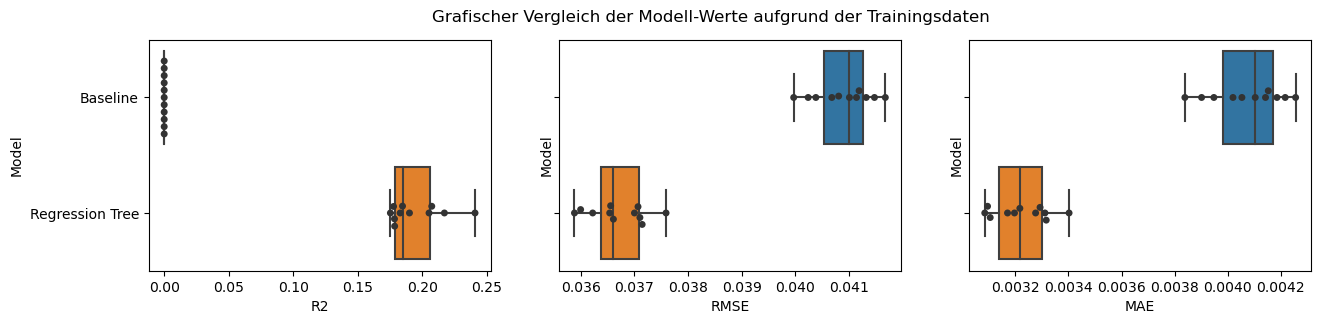

In [95]:
fig, axes = plt.subplots(1,3, figsize=(15, 3), sharey=True)
fig.suptitle('Grafischer Vergleich der Modell-Werte aufgrund der Trainingsdaten')

# R2
sns.boxplot(ax=axes[0], x="R2", y="Model", data=qual_train, whis=np.inf)
sns.swarmplot(ax=axes[0], x="R2", y="Model", data=qual_train, color=".2")

# RMSE
sns.boxplot(ax=axes[1], x="RMSE", y="Model", data=qual_train, whis=np.inf)
sns.swarmplot(ax=axes[1], x="RMSE", y="Model", data=qual_train, color=".2")

# MAE
sns.boxplot(ax=axes[2], x="MAE", y="Model", data=qual_train, whis=np.inf)
sns.swarmplot(ax=axes[2], x="MAE", y="Model", data=qual_train, color=".2")


/Users/manuel/opt/anaconda3/envs/DSIntro_2020/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1249: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
/Users/manuel/opt/anaconda3/envs/DSIntro_2020/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']


<AxesSubplot:xlabel='MAE', ylabel='Model'>

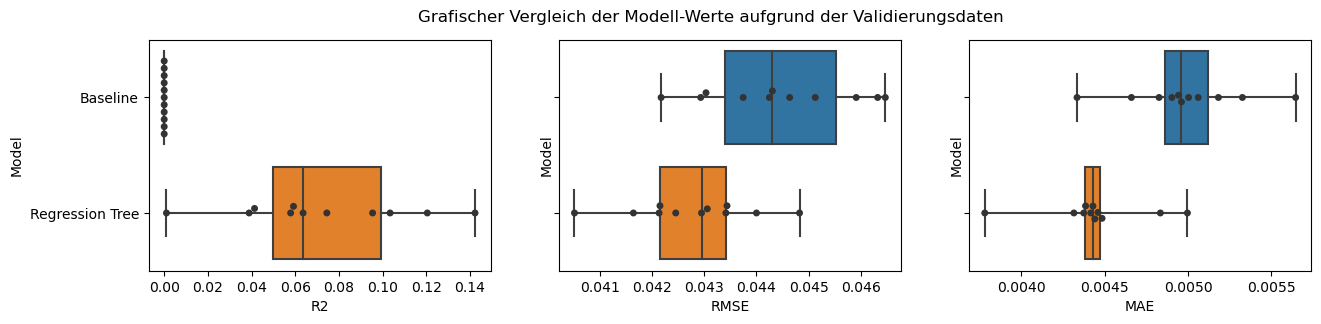

In [96]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3), sharey=True)
fig.suptitle('Grafischer Vergleich der Modell-Werte aufgrund der Validierungsdaten')

# R2
sns.boxplot(ax=axes[0], x="R2", y="Model", data=qual_val, whis=np.inf)
sns.swarmplot(ax=axes[0], x="R2", y="Model", data=qual_val, color=".2")

# RMSE
sns.boxplot(ax=axes[1], x="RMSE", y="Model", data=qual_val, whis=np.inf)
sns.swarmplot(ax=axes[1], x="RMSE", y="Model", data=qual_val, color=".2")

# MAE
sns.boxplot(ax=axes[2], x="MAE", y="Model", data=qual_val, whis=np.inf)
sns.swarmplot(ax=axes[2], x="MAE", y="Model", data=qual_val, color=".2")

In [36]:
# Durchschnitte Baseline
qual_val[qual_val.Model == 'Baseline'].mean()

R2      0.000000
RMSE    0.044446
MAE     0.004986
MAPE         inf
dtype: float64

In [37]:
# Durchschnitte Regression Tree
qual_val[qual_val.Model == 'Regression Tree'].mean()

R2      0.072555
RMSE    0.042779
MAE     0.004447
MAPE         NaN
dtype: float64

Prediciton analysieren:

In [45]:
from sklearn.tree import DecisionTreeRegressor
reg_tree = DecisionTreeRegressor(criterion='squared_error', min_samples_leaf=45)
fitted_tree = reg_tree.fit(m11_train[['year', 'month', 'weekday', 'hour', 'station_nr']].to_numpy(), m11_train[['share']].to_numpy())
val_y_pred  = fitted_tree.predict(m11_val[m11_val.station_nr==161][['year', 'month', 'weekday', 'hour', 'station_nr']].to_numpy())

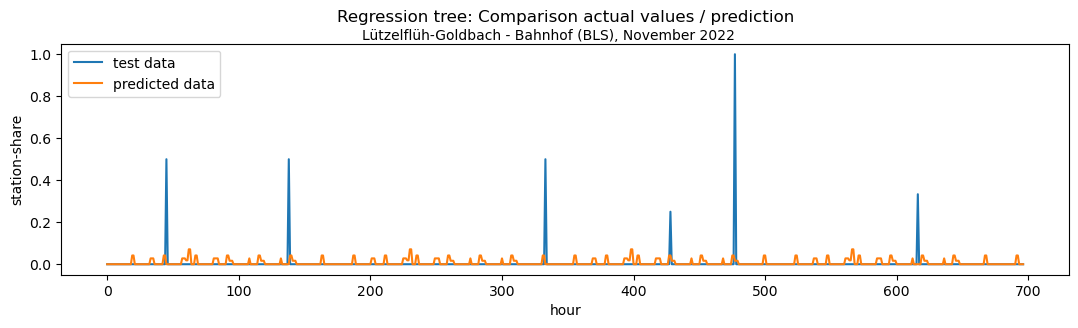

In [112]:
plt.figure(figsize=(13,3))
plt.title('Regression tree: Comparison actual values / prediction', y=1.06)
plt.suptitle('Lützelflüh-Goldbach - Bahnhof (BLS), November 2022', fontsize=10, y=0.93)
plt.ylabel('station-share')
plt.xlabel('hour')
plt.plot(m11_val[m11_val.station_nr==161].share.to_numpy(), label="test data")
plt.plot(val_y_pred, label="predicted data")
plt.legend(loc = 'upper left')

In [47]:
print(m11_val[m11_val.station_nr==161].Station.iloc[0])
print('Durchschnittlicher Share-Anteil gewählte Station: ', m11_val[m11_val.station_nr==161].share.mean())
print('Durchschnittlicher Share-Anteil alle Stationen: ', m11_val.share.mean())
print('Gesamtanzahl Pickups im Zeitraum der Validierungsdaten: ', m11_val[(m11_val.station_nr==161)].cnt.sum())

Lützelflüh-Goldbach - Bahnhof (BLS)
Durchschnittlicher Share-Anteil gewählte Station:  0.004423720707795313
Durchschnittlicher Share-Anteil alle Stationen:  0.002834951992053857
Gesamtanzahl Pickups im Zeitraum der Validierungsdaten:  6.0
